### resources

https://github.com/ultralytics/ultralytics

In [1]:
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from torchvision.transforms.functional import to_pil_image


model = YOLO("../models/ultralytics-yolo-weights/yolov8n-seg.pt", 'yolov8-seg')
image = cv2.imread('../data/images/0je5b4V4MQ0_1.jpg')

/home/alexander/Documents/Programming/ObjectDetection/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### command line run

In [2]:
!yolo predict model=yolov8n.pt source='../data/images/0je5b4V4MQ0_1.jpg'

100%|██████████████████████████████████████| 6.23M/6.23M [00:00<00:00, 22.0MB/s]
Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.1.2+cu121 CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

image 1/1 /home/alexander/Documents/Programming/ObjectDetection/notebooks/../data/images/0je5b4V4MQ0_1.jpg: 640x640 4 persons, 1 bench, 149.6ms
Speed: 5.7ms preprocess, 149.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /home/alexander/Documents/Programming/ObjectDetection/runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


### usecases

In [ ]:
# from ultralytics import YOLO

# # Load a model
# model = YOLO("yolov8n.yaml")  # build a new model from scratch
# model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# # Use the model
# model.train(data="coco128.yaml", epochs=3)  # train the model
# metrics = model.val()  # evaluate model performance on the validation set
# results = model("https://ultralytics.com/images/bus.jpg")  # predict on an image
# path = model.export(format="onnx")  # export the model to ONNX format

### Capture webcam

In [10]:
classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
              "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
              "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
              "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
              "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
              "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli",
              "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
              "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone",
              "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
              "teddy bear", "hair drier", "toothbrush"
              ]

### First approach

In [107]:
# def draw_mask(image, mask_generated) :
#   masked_image = image.copy()
#   masked_image = np.where(mask_generated == 1,np.array((0,200,0), dtype='uint8'),masked_image)
#   masked_image = masked_image.astype(np.uint8)
#   return cv2.addWeighted(image, 0.3, masked_image, 0.7, 0)

In [8]:

def process_image(model, img, stream=False):
    start = time.perf_counter()
    results = model(img, stream=stream)
    end = time.perf_counter()
    total_time = end - start
    fps = 1/total_time
    # print(results)
    
    for r in results:
        boxes = r.boxes
        masks = r.masks
    
        for box, mask in zip(boxes, masks):
            # print(mask)
            # bounding box
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2) # convert to int values

            # confidence
            # confidence = math.ceil((box.conf[0]*100))/100
            # print("Confidence --->",confidence)

            # class name
            cls = int(box.cls[0])
            # print("Class name -->", classNames[cls])

            # object details
            org = [x1, y1]
            font = cv2.FONT_HERSHEY_SIMPLEX
            fontScale = 1
            color = (255, 0, 0)
            thickness = 2
            cv2.putText(img, f'FPS: {int(fps)}', (30,30), font, fontScale, color, thickness)
            
            if classNames[cls] == 'person':
                # img = r.plot()  # plot a BGR numpy array of predictions
                # draw_segmentation_masks(img, masks=mask, alpha=0.7)
                # Mask
                # draw_mask(img, mask.xy[0])
                # Class name
                cv2.putText(img, classNames[cls], org, font, fontScale, color, thickness)
                # put box in cam
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 255), 3)
                
    return img


### Second approach

In [5]:
# from ultralytics.utils.ops import scale_image

def predict_on_image(model, img, conf):
    result = model(img, conf=conf)[0]

    # detection
    # result.boxes.xyxy   # box with xyxy format, (N, 4)
    cls = result.boxes.cls.cpu().numpy()    # cls, (N, 1)
    probs = result.boxes.conf.cpu().numpy()  # confidence score, (N, 1)
    boxes = result.boxes.xyxy.cpu().numpy()   # box with xyxy format, (N, 4)

    # segmentation
    # masks = result.masks.masks.cpu().numpy()     # masks, (N, H, W)
    masks = result.masks.xyn #.cpu().numpy()     # masks, (N, H, W)
    masks = np.moveaxis(masks, 0, -1) # masks, (H, W, N)
    # rescale masks to original image
    # masks = scale_image(masks.shape[:2], masks, result.masks.orig_shape)
    # masks = np.moveaxis(masks, -1, 0) # masks, (N, H, W)

    return boxes, masks, cls, probs


def overlay(image, mask, color, alpha, resize=None):
    """Combines image and its segmentation mask into a single image.
    https://www.kaggle.com/code/purplejester/showing-samples-with-segmentation-mask-overlay

    Params:
        image: Training image. np.ndarray,
        mask: Segmentation mask. np.ndarray,
        color: Color for segmentation mask rendering.  tuple[int, int, int] = (255, 0, 0)
        alpha: Segmentation mask's transparency. float = 0.5,
        resize: If provided, both image and its mask are resized before blending them together.
        tuple[int, int] = (1024, 1024))

    Returns:
        image_combined: The combined image. np.ndarray

    """
    color = color[::-1]
    colored_mask = np.expand_dims(mask, 0).repeat(3, axis=0)
    colored_mask = np.moveaxis(colored_mask, 0, -1)
    masked = np.ma.MaskedArray(image, mask=colored_mask, fill_value=color)
    image_overlay = masked.filled()

    if resize is not None:
        image = cv2.resize(image.transpose(1, 2, 0), resize)
        image_overlay = cv2.resize(image_overlay.transpose(1, 2, 0), resize)

    image_combined = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)

    return image_combined

In [ ]:
# Load a model
# model = YOLO('runs/segment/train_640/weights/best.pt')

# # load image by OpenCV like numpy.array
# img = cv2.imread('frame_00001.PNG')

# # predict by YOLOv8
# boxes, masks, cls, probs = predict_on_image(model, img, conf=0.55)

# # overlay masks on original image
# image_with_masks = np.copy(img)
# for mask_i in masks:
#     image_with_masks = overlay(image_with_masks, mask_i, color=(0,255,0), alpha=0.3)

# # Saving the image
# cv2.imwrite('frame_00001_with_masks.PNG', image_with_masks)

In [6]:
def process_image(model, img):
    start = time.perf_counter()
    results = model(img)
    end = time.perf_counter()
    total_time = end - start
    fps = 1/total_time
    # predict by YOLOv8
    boxes, masks, cls, probs = predict_on_image(model, img, conf=0.55)

    # overlay masks on original image
    image_with_masks = np.copy(img)
    for mask_i in masks:
        image_with_masks = overlay(image_with_masks, mask_i, color=(0,255,0), alpha=0.3)
        
    return img


### Image Prediction

0: 640x640 1 person, 1 horse, 128.4ms
Speed: 4.3ms preprocess, 128.4ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)


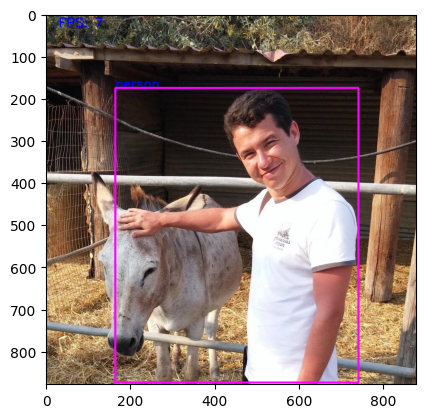

In [11]:
image = cv2.imread('../data/images/7Dy2eue2_3I_1.jpg')
result = process_image(model, image)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
# to_pil_image(result)

In [67]:
import time
cap = cv2.VideoCapture(0)
cap.set(3, 640)
cap.set(4, 480)

while True:
    ret, img= cap.read()
    
    img = process_image(model, img)
    # Code here
    
    cv2.imshow('Webcam', img)
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


0: 480x640 1 person, 53.4ms
Speed: 2.3ms preprocess, 53.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'appl

### Capture from file

In [57]:
import cv2
import time
from ultralytics import YOLO

model = YOLO("../models/ultralytics-yolo-weights/yolov8n-seg.pt", 'yolov8-seg')
video_path = '../data/video/ihome - coming home.mp4'

# cap = cv2.VideoCapture(video_path)
cap = cv2.VideoCapture(0) # for camera capture
cap.set(3, 640)
cap.set(4, 480)

while cap.isOpened():
    success, frame = cap.read()
    if success:
        # start = time.perf_counter()
        # results = model(frame)
        # end = time.perf_counter()
        # total_time = end - start
        # fps = 1/total_time
        # annotated_frame = results[0].plot()
        # cv2.putText(annotated_frame, f"FPS: {int(fps)}", (20,20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
        # cv2.imshow('Results:',annotated_frame)
        
        process_image(model, frame)
        cv2.imshow('Webcam', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
    
cap.release()
cv2.destroyAllWindows()


0: 480x640 1 person, 1 chair, 70.5ms
Speed: 1.7ms preprocess, 70.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 78.2ms
Speed: 1.4ms preprocess, 78.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 77.6ms
Speed: 1.5ms preprocess, 77.6ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 72.4ms
Speed: 1.1ms preprocess, 72.4ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 74.6ms
Speed: 1.3ms preprocess, 74.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 76.8ms
Speed: 1.3ms preprocess, 76.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 76.2ms
Speed: 1.3ms preprocess, 76.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 52.6ms
Speed: 1.2ms preprocess, 52.6ms inference, 1.7ms postprocess per image 